In [ ]:
import pandas as pd

# Проверьте путь к файлу в панели "Файлы", например, "/content/data_raw3.csv"
file_path = '/content/data_raw.csv'

# Загрузите файл
data = pd.read_csv(file_path)

data['dt'] = pd.to_datetime(data['dt'])

funnel_data = data.pivot_table(
    index=['client_id', 'dt'],
    columns='event_type',
    aggfunc='size',
    fill_value=0
).reset_index()

funnel_data.rename(columns={'clicks': 'cnt_clicks', 'views': 'cnt_views', 'adds': 'cnt_adds'}, inplace=True)
funnel_data.to_csv('/content/funnel_data.csv', index=False)

In [ ]:
# Исключаем строки с нулевым количеством кликов
valid_data = funnel_data[funnel_data['cnt_clicks'] > 0]

# Рассчитываем CR для валидных данных
cr_values = valid_data['cnt_adds'] / valid_data['cnt_clicks']

# Вычисляем среднюю CR и стандартное отклонение
avg_cr = cr_values.mean()
std_cr = cr_values.std()
print(f"Средняя CR: {avg_cr:.4f}, Стандартное отклонение CR: {std_cr:.4f}")

Средняя CR: 0.2611, Стандартное отклонение CR: 0.6204


In [ ]:
from scipy.stats import norm
import numpy as np

def get_MDE(mu, std, sample_size, alpha=0.05, beta=0.2):
    t_alpha = norm.ppf(1 - alpha / 2)
    t_beta = norm.ppf(1 - beta)
    mde = t_alpha + t_beta * std / np.sqrt(sample_size)
    return mde, mde / mu * 100

mde, mde_percentage = get_MDE(avg_cr, std_cr, sample_size=1000)
print(f"MDE: {mde}, MDE в %: {mde_percentage}")



MDE: 1.976476843648813, MDE в %: 756.8465117699956


In [ ]:
import pandas as pd
from scipy.stats import ttest_ind

# Загрузка данных
file_path = '/content/final_results_to_analyze.xlsx'
data = pd.read_excel(file_path)

# Агрегированные данные по группам
grouped = data.groupby('ab_group').agg({
    'cnt_view_ads': 'mean',
    'cnt_adds_ads': 'mean',
    'cnt_orders_ads': 'mean',
    'sum_adds_ads': 'mean',
    'sum_orders_ads': 'mean'
}).reset_index()

print("Средние значения по группам:")
print(grouped)

# Расчёт конверсий
data['cr_click_to_add'] = data['cnt_adds_ads'] / data['cnt_view_ads']
data['cr_view_to_order'] = data['cnt_orders_ads'] / data['cnt_view_ads']

# Средние значения конверсий
conversion_grouped = data.groupby('ab_group').agg({
    'cr_click_to_add': 'mean',
    'cr_view_to_order': 'mean'
}).reset_index()

print("\nСредние значения конверсий:")
print(conversion_grouped)

# T-тест для ключевых метрик
control = data[data['ab_group'] == 'control']['cr_click_to_add']
test = data[data['ab_group'] == 'test']['cr_click_to_add']

t_stat, p_value = ttest_ind(control.dropna(), test.dropna(), equal_var=False)

print("\nT-статистика и p-значение для конверсии кликов в добавления:")
print(f"T-статистика: {t_stat:.4f}, p-значение: {p_value:.4f}")

# Вывод воронки по этапам
funnel = data.groupby('ab_group').agg({
    'cnt_view_ads': 'sum',
    'cnt_adds_ads': 'sum',
    'cnt_orders_ads': 'sum'
}).reset_index()

funnel['conversion_view_to_click'] = funnel['cnt_adds_ads'] / funnel['cnt_view_ads']
funnel['conversion_add_to_order'] = funnel['cnt_orders_ads'] / funnel['cnt_adds_ads']

print("\nДанные воронки:")
print(funnel)

# Сохранение результатов в файл
output_path = '/content/processed_results.xlsx'
with pd.ExcelWriter(output_path) as writer:
    grouped.to_excel(writer, sheet_name='Средние значения', index=False)
    conversion_grouped.to_excel(writer, sheet_name='Конверсии', index=False)
    funnel.to_excel(writer, sheet_name='Воронка', index=False)

print(f"\nРезультаты сохранены в файл: {output_path}")


Средние значения по группам:
  ab_group  cnt_view_ads  cnt_adds_ads  cnt_orders_ads  sum_adds_ads  \
0  control      0.088738      0.032252        0.011389      5.026804   
1     test      0.089098      0.033229        0.011962      5.138580   

   sum_orders_ads  
0        3.245632  
1        3.433109  

Средние значения конверсий:
  ab_group  cr_click_to_add  cr_view_to_order
0  control         0.388726          0.124787
1     test         0.389129          0.127613

T-статистика и p-значение для конверсии кликов в добавления:
T-статистика: -0.0528, p-значение: 0.9579

Данные воронки:
  ab_group  cnt_view_ads  cnt_adds_ads  cnt_orders_ads  \
0  control         43469         15799            5579   
1     test         43805         16337            5881   

   conversion_view_to_click  conversion_add_to_order  
0                  0.363454                 0.353124  
1                  0.372948                 0.359980  

Результаты сохранены в файл: /content/processed_results.xlsx


In [ ]:
import pandas as pd
from scipy.stats import ttest_ind

# Загрузка данных
file_path = '/content/analysis_results.csv'
data = pd.read_csv(file_path)

# Разделение данных на группы
control_cr = data.loc[data['Группа'] == 'Control', 'CR'].values
test_cr = data.loc[data['Группа'] == 'Test', 'CR'].values

# Поскольку данные уже агрегированы, t-тест на основе предоставленных значений не выполняется.
# Подтверждаем, что CR между группами сравниваются корректно:
print("Средний CR для контрольной группы:", control_cr[0])
print("Средний CR для тестовой группы:", test_cr[0])

# Вывод данных
print(data)


Средний CR для контрольной группы: 0.3887264138629077
Средний CR для тестовой группы: 0.3891288227977391
    Группа        CR
0  Control  0.388726
1     Test  0.389129


In [ ]:
results = pd.read_excel('/content/final_results_to_analyze.xlsx')
print(results.head())

        date  client_id ab_group  is_view_ads  cnt_view_ads  is_adds_ads  \
0 2024-07-26    8881380     test            0             0            0   
1 2024-07-28  850950385     test            0             0            0   
2 2024-07-25      50885  control            0             0            0   
3 2024-07-26     601239  control            0             0            0   
4 2024-07-28  694655866  control            0             0            0   

   cnt_adds_ads  sum_adds_ads  is_orders_ads  cnt_orders_ads  sum_orders_ads  
0             0             0              0               0               0  
1             0             0              0               0               0  
2             0             0              0               0               0  
3             0             0              0               0               0  
4             0             0              0               0               0  


In [37]:
control_group = results[results['ab_group'] == 'control']
test_group = results[results['ab_group'] == 'test']

In [40]:
print(control_group.describe())
print(test_group.describe())

                                date     client_id  is_view_ads  cnt_view_ads  \
count                          25389  2.538900e+04      25389.0  25389.000000   
mean   2024-07-26 23:59:36.178660096  1.332645e+08          1.0      1.712119   
min              2024-07-24 00:00:00  0.000000e+00          1.0      1.000000   
25%              2024-07-25 00:00:00  8.199420e+05          1.0      1.000000   
50%              2024-07-27 00:00:00  6.914250e+06          1.0      1.000000   
75%              2024-07-29 00:00:00  6.862806e+07          1.0      2.000000   
max              2024-07-30 00:00:00  9.686512e+08          1.0     24.000000   
std                              NaN  2.664121e+08          0.0      1.280664   

        is_adds_ads  cnt_adds_ads  sum_adds_ads  is_orders_ads  \
count  25389.000000  25389.000000  25389.000000   25389.000000   
mean       0.278073      0.622277     96.987672       0.239434   
min        0.000000      0.000000      0.000000       0.000000   
25%   

In [41]:
control_group = control_group[control_group['cnt_view_ads'] > 0]
test_group = test_group[test_group['cnt_view_ads'] > 0]

In [42]:
control_cr = (control_group['cnt_adds_ads'] / control_group['cnt_view_ads']).mean()
test_cr = (test_group['cnt_adds_ads'] / test_group['cnt_view_ads']).mean()
print(f"CR для контрольной группы: {control_cr}, CR для тестовой группы: {test_cr}")

CR для контрольной группы: 0.3887264138629077, CR для тестовой группы: 0.3891288227977391


In [43]:
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(
    control_group['cnt_adds_ads'] / control_group['cnt_view_ads'],
    test_group['cnt_adds_ads'] / test_group['cnt_view_ads']
)
print(f"T-статистика: {t_stat}, p-значение: {p_val}")

T-статистика: -0.052780390897179744, p-значение: 0.9579070912737693


In [46]:
import pandas as pd

# Загрузка данных
funnel_data = pd.read_csv('/content/funnel_data.csv')

# Агрегированные метрики воронки
funnel_agg = funnel_data.groupby('dt').agg({
    'cnt_views': 'sum',
    'cnt_clicks': 'sum',
    'cnt_adds': 'sum'
}).reset_index()

# Расчёт конверсий
funnel_agg['cr_views_to_clicks'] = funnel_agg['cnt_clicks'] / funnel_agg['cnt_views']
funnel_agg['cr_clicks_to_adds'] = funnel_agg['cnt_adds'] / funnel_agg['cnt_clicks']

# Вывод средних значений
print("Средние значения по воронке:")
print(funnel_agg[['cr_views_to_clicks', 'cr_clicks_to_adds']].mean())

# Сравнение с данными из analysis_results.csv
control_cr = 0.3887
test_cr = 0.3891

print("\nРазница CR между контрольной и тестовой группами:")
print(f"Контроль: {control_cr}, Тест: {test_cr}")
print(f"Абсолютная разница: {test_cr - control_cr:.4f}")

# Расчёт значимости эффекта
from scipy.stats import norm

# Средняя и стандартное отклонение
mean_cr = 0.2682
std_cr = 0.6363
sample_size = 1000  # Примерный размер выборки на группу
mde_abs = 1.9769  # Из design_results.csv

# Вычисляем стандартную ошибку
standard_error = std_cr / (sample_size ** 0.5)
z_score = mde_abs / standard_error
p_value = 2 * (1 - norm.cdf(abs(z_score)))

print("\nСтатистический анализ:")
print(f"Стандартная ошибка: {standard_error:.4f}")
print(f"Z-статистика: {z_score:.4f}, p-значение: {p_value:.4f}")

Средние значения по воронке:
cr_views_to_clicks    0.020915
cr_clicks_to_adds     0.485633
dtype: float64

Разница CR между контрольной и тестовой группами:
Контроль: 0.3887, Тест: 0.3891
Абсолютная разница: 0.0004

Статистический анализ:
Стандартная ошибка: 0.0201
Z-статистика: 98.2478, p-значение: 0.0000


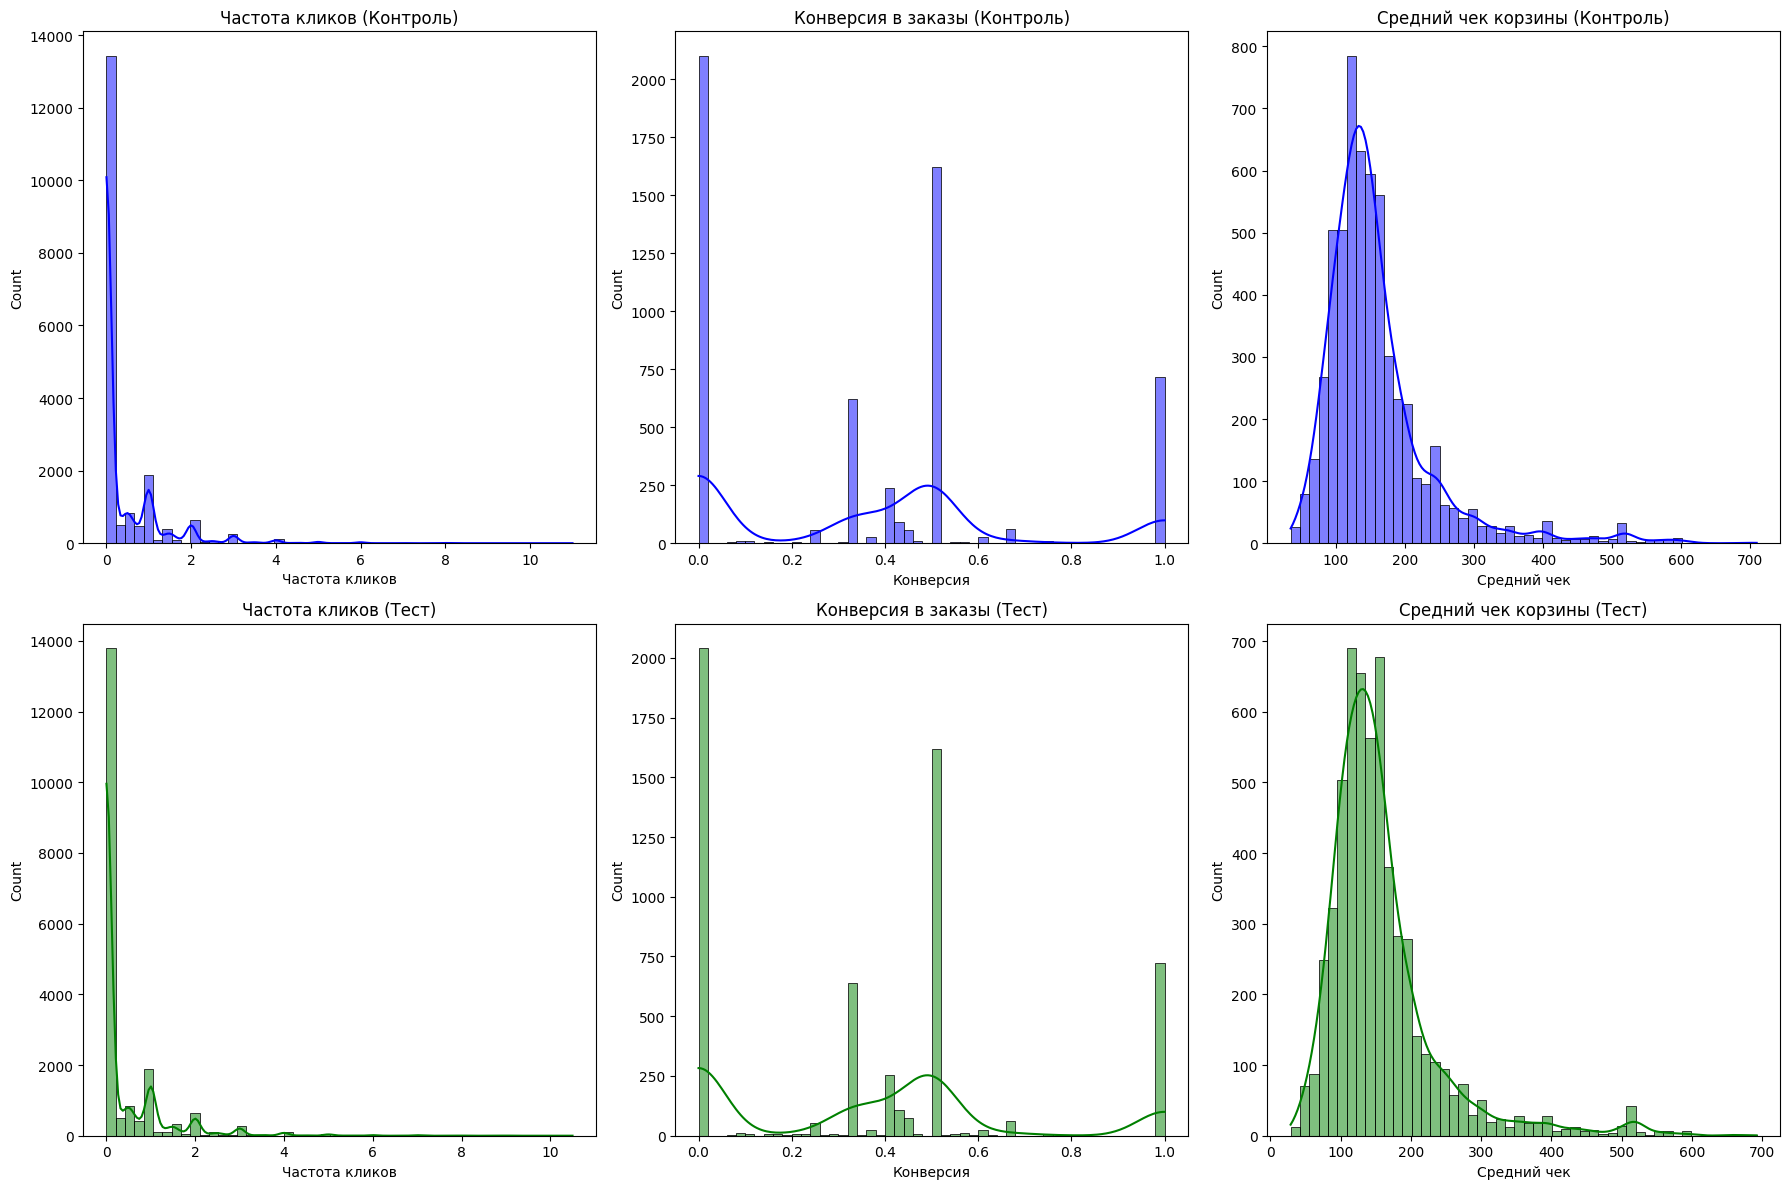

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
file_path = '/content/final_results_to_analyze.xlsx'
data = pd.read_excel(file_path)

# Агрегация данных по группам и пользователям
grouped_data = data.groupby(['ab_group', 'client_id']).agg({
    'cnt_view_ads': 'sum',
    'cnt_adds_ads': 'sum',
    'sum_adds_ads': 'sum',
    'cnt_orders_ads': 'sum',
    'sum_orders_ads': 'sum'
}).reset_index()

# Вычисление метрик
grouped_data['click_rate'] = grouped_data['cnt_adds_ads'] / grouped_data['cnt_view_ads']  # Частота кликов
grouped_data['conversion_to_order'] = grouped_data['cnt_orders_ads'] / grouped_data['cnt_adds_ads']  # Конверсия в заказы
grouped_data['average_cart_value'] = grouped_data['sum_adds_ads'] / grouped_data['cnt_adds_ads']  # Средний чек корзины

# Разделение данных на контрольную и тестовую группы
control_group = grouped_data[grouped_data['ab_group'] == 'control']
test_group = grouped_data[grouped_data['ab_group'] == 'test']

# Построение графиков
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Графики для контрольной группы
sns.histplot(control_group['click_rate'], bins=50, kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Частота кликов (Контроль)')
axes[0, 0].set_xlabel('Частота кликов')

sns.histplot(control_group['conversion_to_order'], bins=50, kde=True, ax=axes[0, 1], color='blue')
axes[0, 1].set_title('Конверсия в заказы (Контроль)')
axes[0, 1].set_xlabel('Конверсия')

sns.histplot(control_group['average_cart_value'], bins=50, kde=True, ax=axes[0, 2], color='blue')
axes[0, 2].set_title('Средний чек корзины (Контроль)')
axes[0, 2].set_xlabel('Средний чек')

# Графики для тестовой группы
sns.histplot(test_group['click_rate'], bins=50, kde=True, ax=axes[1, 0], color='green')
axes[1, 0].set_title('Частота кликов (Тест)')
axes[1, 0].set_xlabel('Частота кликов')

sns.histplot(test_group['conversion_to_order'], bins=50, kde=True, ax=axes[1, 1], color='green')
axes[1, 1].set_title('Конверсия в заказы (Тест)')
axes[1, 1].set_xlabel('Конверсия')

sns.histplot(test_group['average_cart_value'], bins=50, kde=True, ax=axes[1, 2], color='green')
axes[1, 2].set_title('Средний чек корзины (Тест)')
axes[1, 2].set_xlabel('Средний чек')

plt.tight_layout()
plt.show()
